In [25]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model


In [27]:
import json
token = {"username":"eviltrashcan","key":"5a0836e4ef86086fdadf624206bd1421"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [28]:
!cat /content/kaggle.json

{"username": "eviltrashcan", "key": "5a0836e4ef86086fdadf624206bd1421"}

In [29]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [30]:
!kaggle competitions download -c cifar-10

 95% 679M/715M [00:10<00:00, 62.6MB/s]
100% 715M/715M [00:10<00:00, 69.1MB/s]


In [31]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [32]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [33]:
!ls competitions/cifar-10/train|wc -l

50000


In [34]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        """
        初始化CIFAR-10数据集
        参数:
            img_dir: 图片目录路径
            labels_file: 标签文件路径
            transform: 图像预处理转换
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        """返回数据集中样本的数量"""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        获取指定索引的样本
        参数:
            idx: 样本索引
        返回:
            image_tensor: 经过转换的图像张量
            label: 对应的标签
        """
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') # 构建完整图片路径
        image = Image.open(img_path) # 打开图片文件
        label = self.labels[idx]  # 获取对应标签

        if self.transform:
            image_tensor = self.transform(image)  # 应用图像转换

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将PIL图像转换为张量，并将像素值归一化到[0,1]
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))  # 使用CIFAR-10的均值和标准差进行标准化
])

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"  # 训练图像目录
labels_file = r"./trainLabels.csv"  # 标签文件路径
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000  # 训练集大小
val_size = 5000  # 验证集大小
generator = torch.Generator().manual_seed(42)  # 设置随机种子，确保可重复性
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator  # 使用生成器确保划分结果一致
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [35]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




In [36]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # 第一组卷积层 - 使用Sequential组织
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),  # 输入3通道(RGB)，输出128通道，3x3卷积核，padding保持尺寸不变
            nn.BatchNorm2d(128),  # 批量归一化，稳定训练过程
            nn.ReLU(),  # 激活函数，引入非线性
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 第二层卷积，保持通道数不变
            nn.BatchNorm2d(128),  # 批量归一化
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化，将特征图尺寸减半 (32x32 -> 16x16)
        )

        # 第二组卷积层 - 使用Sequential组织
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 输入128通道，输出256通道，特征维度提升
            nn.BatchNorm2d(256),  # 批量归一化
            nn.ReLU(),  # 激活函数
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 保持通道数不变
            nn.BatchNorm2d(256),  # 批量归一化
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化，将特征图尺寸再次减半 (16x16 -> 8x8)
        )

        # 第三组卷积层 - 使用Sequential组织
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 输入256通道，输出512通道，进一步提取高级特征
            nn.BatchNorm2d(512),  # 批量归一化
            nn.ReLU(),  # 激活函数
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 保持通道数不变
            nn.BatchNorm2d(512),  # 批量归一化
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化，将特征图尺寸再次减半 (8x8 -> 4x4)
        )

        # 全连接层 - 使用Sequential组织
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),  # 输入维度为512*4*4(展平后的特征图)，输出1024维特征
            nn.ReLU(),  # 激活函数
            nn.Linear(1024, 10)  # 最终输出层，10个类别对应CIFAR-10数据集
        )

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Xavier初始化，有助于解决深度网络的梯度消失/爆炸问题
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # 偏置初始化为0

    def forward(self, x):
        # 前向传播使用Sequential定义的块
        x = self.conv_block1(x)  # 第一组卷积操作
        x = self.conv_block2(x)  # 第二组卷积操作
        x = self.conv_block3(x)  # 第三组卷积操作

        # 展平操作，将三维特征图转为一维向量
        x = x.view(x.size(0), -1)  # [batch_size, 512*4*4]

        # 通过分类器得到最终预测结果
        x = self.classifier(x)  # [batch_size, 10]

        return x


In [37]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [38]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 12979850
模型总参数量: 12979850

各层参数量明细:
conv_block1.0.weight: 3456 参数
conv_block1.0.bias: 128 参数
conv_block1.1.weight: 128 参数
conv_block1.1.bias: 128 参数
conv_block1.3.weight: 147456 参数
conv_block1.3.bias: 128 参数
conv_block1.4.weight: 128 参数
conv_block1.4.bias: 128 参数
conv_block2.0.weight: 294912 参数
conv_block2.0.bias: 256 参数
conv_block2.1.weight: 256 参数
conv_block2.1.bias: 256 参数
conv_block2.3.weight: 589824 参数
conv_block2.3.bias: 256 参数
conv_block2.4.weight: 256 参数
conv_block2.4.bias: 256 参数
conv_block3.0.weight: 1179648 参数
conv_block3.0.bias: 512 参数
conv_block3.1.weight: 512 参数
conv_block3.1.bias: 512 参数
conv_block3.3.weight: 2359296 参数
conv_block3.3.bias: 512 参数
conv_block3.4.weight: 512 参数
conv_block3.4.bias: 512 参数
classifier.0.weight: 8388608 参数
classifier.0.bias: 1024 参数
classifier.2.weight: 10240 参数
classifier.2.bias: 10 参数


In [39]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9
print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0


Training Progress:   0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 80.8800
早停: 已有5轮验证损失没有改善！


In [41]:
history['train'][-100:-1]


[{'loss': 0.005698289722204208, 'acc': 100.0, 'step': 9401},
 {'loss': 0.004647423047572374, 'acc': 100.0, 'step': 9402},
 {'loss': 0.004613662604242563, 'acc': 100.0, 'step': 9403},
 {'loss': 0.004719239193946123, 'acc': 100.0, 'step': 9404},
 {'loss': 0.005033548921346664, 'acc': 100.0, 'step': 9405},
 {'loss': 0.00471144774928689, 'acc': 100.0, 'step': 9406},
 {'loss': 0.004823734983801842, 'acc': 100.0, 'step': 9407},
 {'loss': 0.009813947603106499, 'acc': 100.0, 'step': 9408},
 {'loss': 0.004382151644676924, 'acc': 100.0, 'step': 9409},
 {'loss': 0.004386579152196646, 'acc': 100.0, 'step': 9410},
 {'loss': 0.004786801058799028, 'acc': 100.0, 'step': 9411},
 {'loss': 0.003678069682791829, 'acc': 100.0, 'step': 9412},
 {'loss': 0.004076982848346233, 'acc': 100.0, 'step': 9413},
 {'loss': 0.005846087355166674, 'acc': 100.0, 'step': 9414},
 {'loss': 0.0057292478159070015, 'acc': 100.0, 'step': 9415},
 {'loss': 0.0035347421653568745, 'acc': 100.0, 'step': 9416},
 {'loss': 0.00617369776

In [42]:
history['val'][-1000:-1]

[{'loss': 2.3040840320587157, 'acc': 8.58, 'step': 0},
 {'loss': 1.0997572706222534, 'acc': 60.38, 'step': 500},
 {'loss': 0.8982386985778809, 'acc': 67.52, 'step': 1000},
 {'loss': 0.8121403874397278, 'acc': 71.68, 'step': 1500},
 {'loss': 0.783211523103714, 'acc': 72.42, 'step': 2000},
 {'loss': 0.6996137134552002, 'acc': 75.92, 'step': 2500},
 {'loss': 0.7319747125148773, 'acc': 75.34, 'step': 3000},
 {'loss': 0.6958818212509156, 'acc': 76.08, 'step': 3500},
 {'loss': 0.6817657352924347, 'acc': 77.54, 'step': 4000},
 {'loss': 0.672947887468338, 'acc': 79.52, 'step': 4500},
 {'loss': 0.6774132533073425, 'acc': 78.92, 'step': 5000},
 {'loss': 0.7014308073043823, 'acc': 79.6, 'step': 5500},
 {'loss': 0.6835381038665771, 'acc': 79.98, 'step': 6000},
 {'loss': 0.6985765370845795, 'acc': 80.16, 'step': 6500},
 {'loss': 0.6987924649715423, 'acc': 80.88, 'step': 7000},
 {'loss': 0.705199195766449, 'acc': 80.56, 'step': 7500},
 {'loss': 0.7222976142168045, 'acc': 80.6, 'step': 8000},
 {'loss

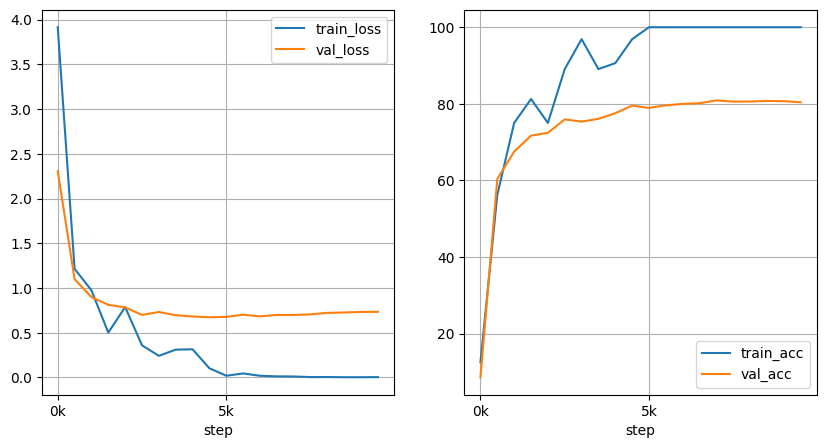

In [43]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [44]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [45]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir  # 存储图像目录路径
        self.transform = transform  # 存储图像变换操作
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]  # 获取所有PNG图像文件名

    def __len__(self):
        return len(self.img_files)  # 返回数据集大小

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])  # 构建完整图像路径
        image = Image.open(img_path).convert('RGB')  # 打开图像并转换为RGB格式

        if self.transform:
            image = self.transform(image)  # 应用图像变换

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])  # 从文件名中提取ID

        return image, img_id  # 返回图像和对应ID

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),  # 将PIL图像转换为张量
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))  # 使用CIFAR-10的均值和标准差进行标准化
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)  # 实例化测试数据集
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)  # 创建数据加载器，不打乱顺序

    # 设置模型为评估模式
    model.eval()  # 切换到评估模式，禁用dropout等

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)  # 加载提交模板CSV文件
    predictions = {}  # 存储预测结果的字典

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():  # 禁用梯度计算，减少内存使用并加速推理
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):  # 遍历测试数据集
            images = images.to(device)  # 将图像数据移动到指定设备(CPU/GPU)
            outputs = model(images)  # 通过模型获取预测输出
            _, predicted = torch.max(outputs, 1)  # 取最大值的索引作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item()  # 将张量值转换为Python数值并存储

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR-10的10个类别

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}  # 将数字标签映射为类别名称

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),  # 图像ID列
        'label': list(labeled_predictions.values())  # 预测类别列
    })
    # 按id列排序
    submission_df = submission_df.sort_values(by='id')  # 确保结果按ID排序

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()  # 检查是否有重复ID
    print(f"id列是否有重复值: {has_duplicates}")
    # 保存预测结果
    output_file = 'cifar10_submission.csv'  # 输出文件名
    submission_df.to_csv(output_file, index=False)  # 保存为CSV文件，不包含索引列
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
img_dir = r"competitions/cifar-10/test"  # 测试图像目录
labels_file = r"./sampleSubmission.csv"  # 提交模板文件
predict_test_set(model, img_dir, labels_file, device, batch_size=128)  # 调用预测函数，批次大小为128


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


正在预测测试集...


预测进度:   0%|          | 0/2344 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
预测进度: 100%|██████████| 2344/2344 [02:01<00:00, 19.34it/s]


id列是否有重复值: False
预测完成，结果已保存至 cifar10_submission.csv


In [46]:
!head -10 cifar10_submission.csv

id,label
1,deer
2,airplane
3,automobile
4,ship
5,bird
6,cat
7,airplane
8,cat
9,bird


In [47]:
!wc -l cifar10_submission.csv

300001 cifar10_submission.csv
